In [ ]:
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Align import AlignDlib
from tqdm import tqdm
from model import create_model
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from joblib import dump, load
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
import tensorflow
from keras.initializers import RandomNormal
from keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
import numpy as np
import os.path
import matplotlib.pyplot as plt


import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [ ]:
from zipfile import ZipFile

file_name = "data.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [ ]:
def preprocessingAttackImage(img,process):
  if process == "GRID_BASED" or "MSB_BASED":
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  if process  == "EYE_OCCLUSION":
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #changed here BGR2GRAY

  face_aligned = alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  return face_aligned

In [ ]:
#MSB_ATTACK
from operator import xor
def flipMSB(set_, i, img, size):

  for c in range(size):
    points = set_[c]
    x = int(points[0])
    y = int(points[1])
    b,g,r = img[x][y]

    if i == 1:
      a = b ^ 128
      img[x][y][0] = a

    elif i == 2:
      a = g ^ 128
      img[x][y][1] = a

    elif i == 3:
      a = r ^ 128
      img[x][y][2] = a
  
  return img

import random
import numpy as np

def Create_Sets(parameter, img):

  height = img.shape[0]
  width = img.shape[1]
  size = int (parameter * height * width)
  
  set1 = np.ones((size, 2))
  set2 = np.ones((size, 2))
  set3 = np.ones((size, 2))
  set1.reshape(size, 2)
  set2.reshape(size, 2)
  set3.reshape(size, 2)
  #one.shape

  for i in range(int(size)):
    c = random.randint(0, height-1), random.randint(0, width-1)
    x = img[c[0]][c[1]]
    set1[i] = c

  for i in range(int(size)):
    c = random.randint(0, height-1), random.randint(0, width-1)
    x = img[c[0]][c[1]]
    set2[i] = c
    
  for i in range(int(size)):
    c = random.randint(0, height-1), random.randint(0, width-1)
    x = img[c[0]][c[1]]
    set3[i] = c

  #with np.printoptions(threshold=np.inf):
      #print(one)
  return set1, set2, set3, size

def MSB_Attack(face_aligned, parameter):
  set1, set2, set3, size = Create_Sets(parameter, face_aligned)
  face_aligned = flipMSB(set1, 1, face_aligned, size)
  face_aligned = flipMSB(set2, 2, face_aligned, size)
  face_aligned = flipMSB(set3, 3, face_aligned, size)
  return face_aligned

In [ ]:
#GRID BASED OCCLUSION
import random as rand

def GRID_Attack(img, pgrids):
  x_coordinate = []
  y_coordinate = []

  plt.imshow(img)
  
  height = img.shape
  #height[1] is width and when y = 0 we move along x-axis i.e width
  #height[0] is height and when x = 0 we move along y-axis i.e height
  for no_of_coordinates in range(0,pgrids,2): 
      #generates (x,0) and (x',height)
      x_coordinate.append((rand.randint(1,height[1]),0))
      x_coordinate.append((rand.randint(1,height[1]),height[0])) 
      
      #generates (0,y) and (width, y')
      y_coordinate.append((0,rand.randint(1,height[0])))
      y_coordinate.append((height[1],rand.randint(1,height[0])))

  for num in range(0,pgrids,2):
    cv2.line(img, x_coordinate[num], x_coordinate[num+1],(0,0,0),1)
    cv2.line(img, y_coordinate[num], y_coordinate[num+1],(0,0,0),1)
  return img

In [ ]:
#facial landmark indices developed over years. 
def return_facial_feature_Index(str):
  coordinates = []
  if str == "LEFT EYE":
    coordinates.append((42,48))
  if str == "RIGHT EYE":
    coordinates.append((36,42))
  if str == "RIGHT EYEBROW":
    coordinates.append((17,22))
  if str == "LEFT EYEBROW":
    coordinates.append((22,27))
  if str == "NOSE":
    coordinates.append((27,35))
  if str == "MOUTH":
    coordinates.append((48,68))
  if str == "JAW":
    coordinates.append((0,17))
  if str == "LIPS":
    coordinates.append((61,67))
  return coordinates

In [ ]:
import dlib
import numpy as np
def EYE_Attack(img,BandWidth):
  global landmarks
  # Load the detector
  detector = dlib.get_frontal_face_detector()
  # Load the predictor
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  # Use detector to find landmarks
  faces = detector(img)
  image_mod = np.copy(img)
  #landmarks = predictor(img,faces[0])
  #dimensions of face
  for face in faces:
      x_left = face.left() 
      y_top = face.top() 
      x_right = face.right() 
      y_bottom = face.bottom() 

      # Look for the landmarks
      landmarks = predictor(img, face)
      landmark_region = []
      #The landmarks consists of a shape object containing the 68 (x, y)-coordinates of the facial landmark regions.
      for x1 in range(67):
        landmark_region.append((landmarks.part(x1).x,landmarks.part(x1).y))

      for (x,y) in landmark_region:
        cv2.circle(image_mod, (x,y), 1, (0, 255, 0),6) #shows all the landmarks

  plt.imshow(image_mod)

  Left_eye = return_facial_feature_Index("LEFT EYE") #returns indices for image of left eye
  Right_eye = return_facial_feature_Index("RIGHT EYE") #returns indices for image of right eye

  h = img.shape
  #name of the part that lies at the end of right eye
  #x and y coordinates of the part name
  x = 0
  x2 = h[1]

  Z = Left_eye[0][1] -1
  y_re = landmarks.part(Right_eye[0][0]).y
  y_le = landmarks.part(Z).y
  x_re = landmarks.part(Right_eye[0][0]).x
  x_le = landmarks.part(Z).x

  distance_eye = x_re - x_le
  y_e = (y_le + y_re)/2
  param = distance_eye/BandWidth
  y1 = int(y_e - param)
  y2 = int(y_e + param)
  x = landmarks.part(Right_eye[0][0]).x
  x2 = landmarks.part(Z).x
  y1 = landmarks.part(Right_eye[0][0]).x
  y2 = landmarks.part(Z).y

  cv2.rectangle(img,(x,y1),(x2,y2),(0,0,0),25)
  return img

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [ ]:
def extensions(path):
    extension = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            extension.append(ext)
    return np.array(extension)

extension = extensions('/content/data')

In [ ]:
(pd.Series(extension)).value_counts()

.jpg    27
.png     3
dtype: int64

In [ ]:
def load_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg' or ext=='.JPG' or ext=='.png':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

In [ ]:
##FGSM 


In [ ]:
#ATTACKING IMAGES HERE
import os
from PIL import Image
alignment = AlignDlib('models/landmarks.dat')

def AttackImage(attackName):
  i = 0
  for path, _, files in os.walk('/content/data'):
      for file in files:
          img_path = os.path.join(path, file)
          #print(os.path.join(path, file))
          if i % 5 == 0:
            img = cv2.imread(img_path)
            if attackName == "MSB_BASED":
              image = preprocessingAttackImage(img,"MSB_BASED")
              face_aligned = MSB_Attack(image, 0.2)
            if attackName == "GRID_BASED":
              image = preprocessingAttackImage(img,"GRID_BASED")
              pgrids = 20
              face_aligned = GRID_Attack(image, pgrids)
            if attackName == "EYE_OCCLUSION":
              image = preprocessingAttackImage(img,"EYE_OCCLUSION")
              band = 10
              face_aligned = EYE_Attack(image,band)

            plt.imshow(face_aligned)
            pil_img = Image.fromarray(face_aligned)
            n = pil_img
            pil_img.save(img_path)
          i = i + 1

          

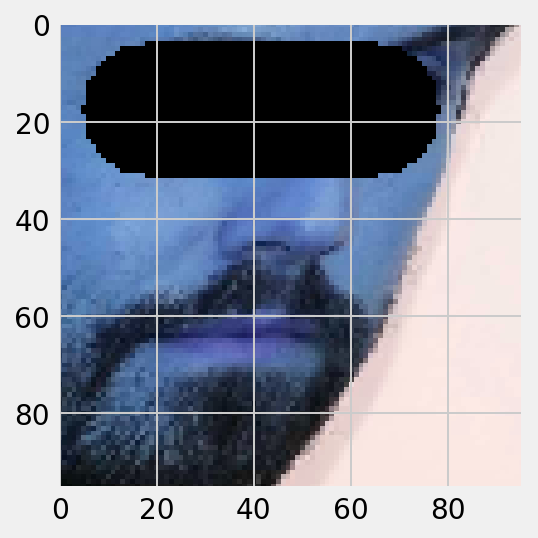

In [ ]:
#Selecting Attack here
AttackImage("EYE_OCCLUSION")

In [ ]:
metadata = load_metadata('/content/data')

In [ ]:
names = np.array([m.name for m in metadata])

In [ ]:
pd.Series(names).value_counts()[:5]

alexis bledel       11
milo ventimiglia    10
lauren graham        9
dtype: int64

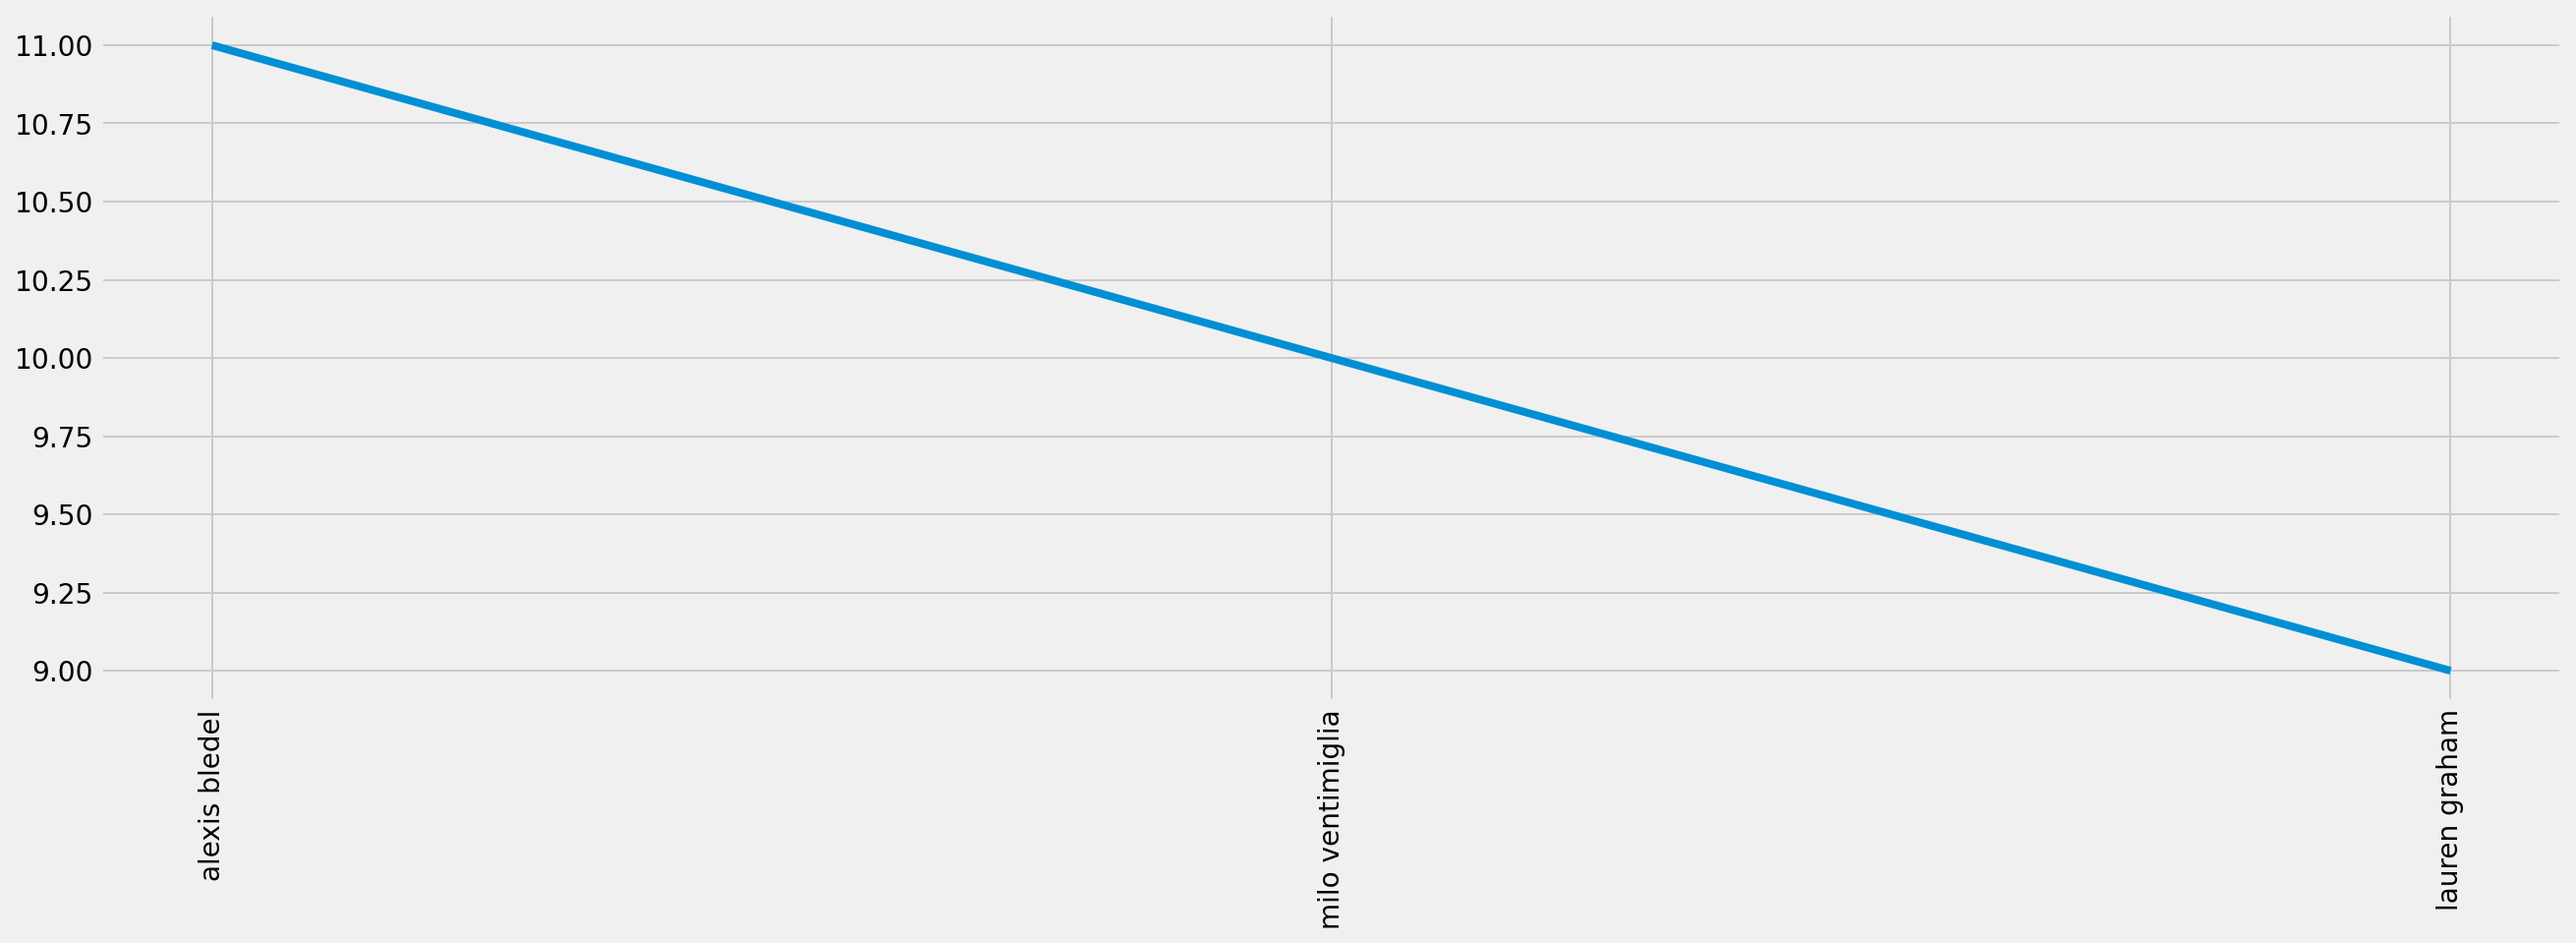

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(pd.Series(names).value_counts())
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]
  
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [ ]:
#Load pretrained Model

model = create_model()
model.load_weights('open_face.h5')

In [ ]:
from __future__ import division
embedded = np.zeros((metadata.shape[0], 128))
j = 0
for i, m in tqdm(enumerate(metadata)):

    img = load_image(m.image_path())
    if(j % 5 != 0):
      img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = model.predict(np.expand_dims(img, axis=0))[0]
    j = j + 1

30it [00:28,  1.07it/s]


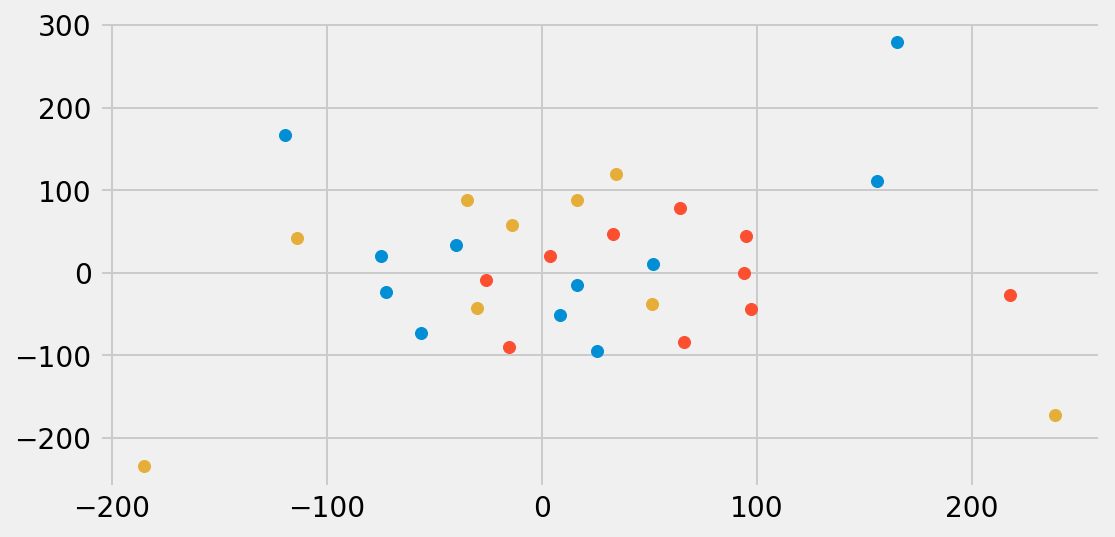

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(names)):
    idx = names == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

In [ ]:
print("Train data:",(embedded.shape))
print("Output class:",(names.shape))

Train data: (30, 128)
Output class: (30,)


In [ ]:
df = pd.DataFrame(embedded)
df["output"] = names
df.to_csv("embedded_629_celeb.csv",index=False)

In [ ]:
from sklearn.preprocessing import LabelEncoder

names_encode = LabelEncoder().fit(names)
Y = names_encode.transform(names)

In [ ]:
# save
np.save('names_encode.npy', names_encode.classes_)

In [ ]:
y = np.zeros((embedded.shape[0],len(set(Y))),dtype=int)
y.shape

(30, 3)

In [ ]:
for i,name in enumerate(names):
  ind = Y[i]
  y[i][ind]=1

In [ ]:
train_idx = np.arange(embedded.shape[0]) % 5 != 0
test_idx = np.arange(embedded.shape[0]) % 5 == 0

print(np.sum(train_idx))
print(np.sum(test_idx))

24
6


In [ ]:
X_train = embedded[train_idx]
y_train = y[train_idx]

X_val = embedded[test_idx]
y_val = y[test_idx]

In [ ]:
output_dim = y_train.shape[1]
input_dim = X_train.shape[1]

batch_size = 8
nb_epoch = 500

In [ ]:
import keras

In [ ]:
model_relu = Sequential()

model_relu.add(Dense(250, activation='relu', input_shape=(input_dim,), kernel_initializer=keras.initializers.he_normal(seed=None)))
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.5))

model_relu.add(Dense(100, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_relu.add(BatchNormalization())
model_relu.add(Dropout(0.5))

model_relu.add(Dense(output_dim,activation='softmax'))

print(model_relu.summary())

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 250)               32250     
_________________________________________________________________
batch_normalization_64 (Batc (None, 250)               1000      
_________________________________________________________________
dropout_64 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 100)               25100     
_________________________________________________________________
batch_normalization_65 (Batc (None, 100)               400       
_________________________________________________________________
dropout_65 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 3)               

In [ ]:
model_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=(X_val,y_val))

Epoch 1/500
3/3 [==============================] - 1s 98ms/step - loss: 2.2032 - accuracy: 0.2135 - val_loss: 1.0888 - val_accuracy: 0.1667
Epoch 2/500
3/3 [==============================] - 0s 22ms/step - loss: 1.2591 - accuracy: 0.3698 - val_loss: 1.0641 - val_accuracy: 0.3333
Epoch 3/500
3/3 [==============================] - 0s 26ms/step - loss: 0.4865 - accuracy: 0.7500 - val_loss: 1.0405 - val_accuracy: 0.3333
Epoch 4/500
3/3 [==============================] - 0s 22ms/step - loss: 0.1690 - accuracy: 0.9792 - val_loss: 1.0183 - val_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 24ms/step - loss: 0.2673 - accuracy: 0.8073 - val_loss: 0.9993 - val_accuracy: 0.6667
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 0.1798 - accuracy: 0.8958 - val_loss: 0.9844 - val_accuracy: 0.6667
Epoch 7/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.9694 - val_accuracy: 0.6667
Epoch 8/500
3/3 [===

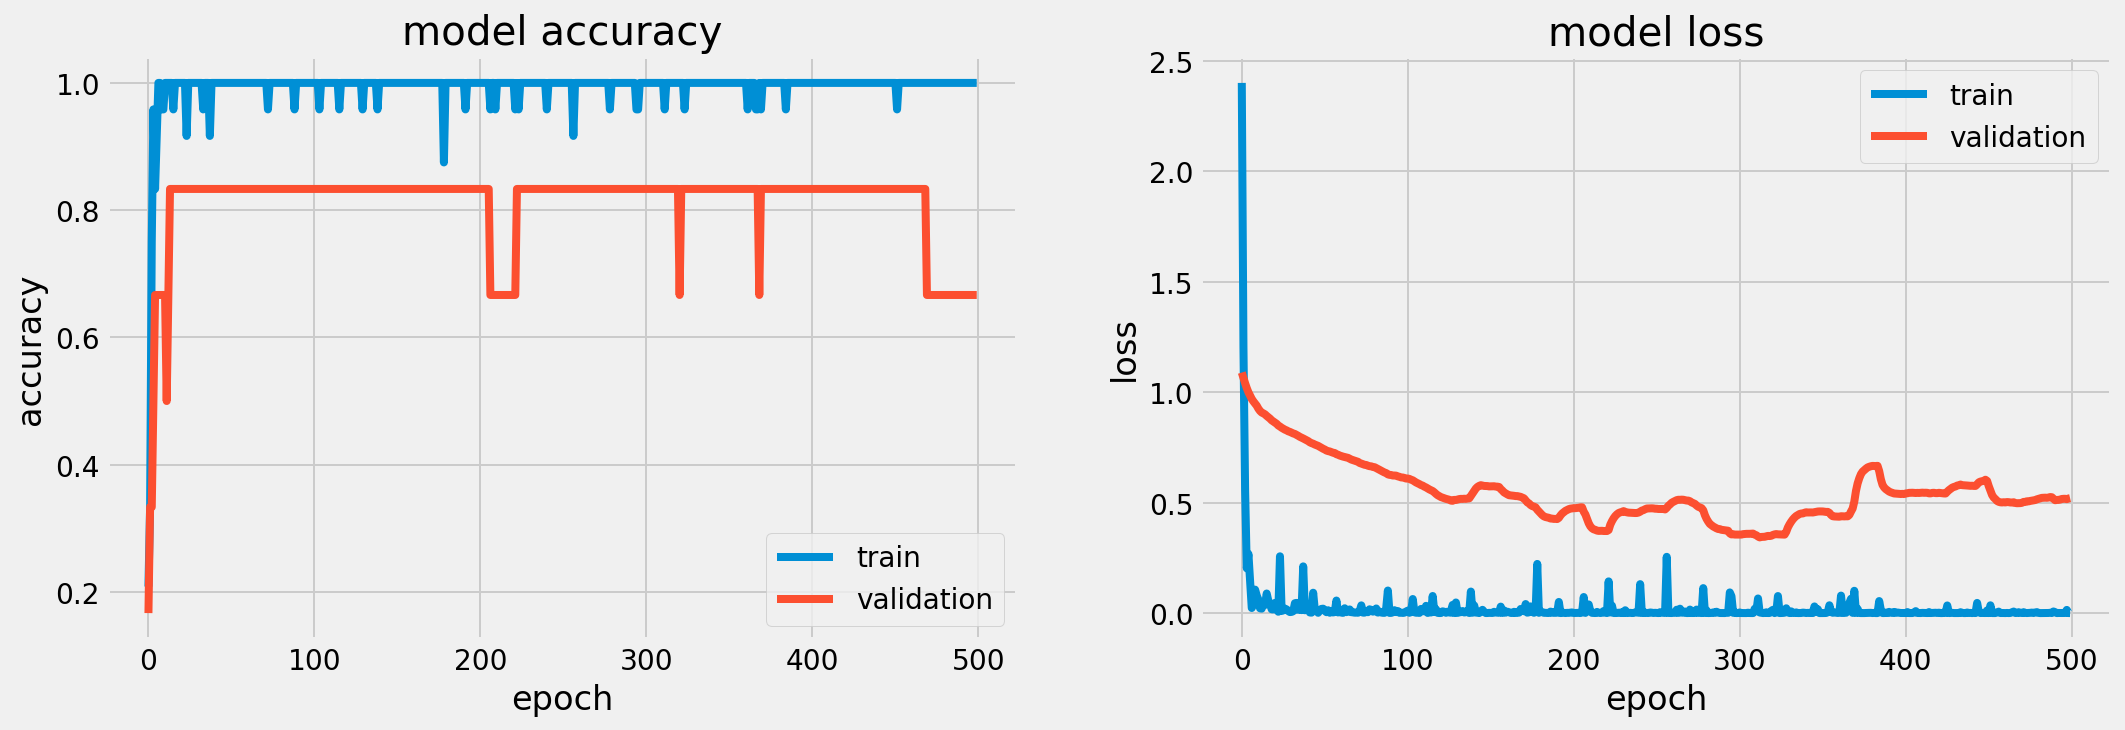

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()